In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.sparse.csgraph import laplacian
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris as iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#6. A) Transforme o exemplo que inicia no slide 55 em código, plotando os histogramas, os cálculos de probabilidades e o resultado da classificação.
Organize as probabilidades em tabelas usando Pandas. Ao final, crie uma função na qual seja dada uma sequência como mostrada abaixo e ela retorne o resultado da classificação. <br>
$$
```LUNCH MONEY MONEY MONEY MONEY```
$$

In [83]:
#nao spam
dear = shuffle([1] * 8)
friend = shuffle([1] * 5 + [0] * 3)
lunch = shuffle([1] * 3 + [0] * 5)
money = shuffle([1] * 1 + [0] * 7)

no_spam = pd.DataFrame({
    'Dear': dear,
    'Friend': friend,
    'Lunch': lunch,
    'Money': money,
})

#spam
dearS = shuffle([1] * 2 + [0] * 2)
friendS = shuffle([1] * 1 + [0] * 3)
lunchS = shuffle([0] * 4)
moneyS = shuffle([1] *4)

spam = pd.DataFrame({
    'Dear': dearS,
    'Friend': friendS,
    'Lunch': lunchS,
    'Money': moneyS,
})

In [84]:
spam

,Dear,Friend,Lunch,Money
0,1,0,0,1
1,0,0,0,1
2,1,0,0,1
3,0,1,0,1


In [85]:
no_spam

,Dear,Friend,Lunch,Money
0,1,0,0,0
1,1,1,1,0
2,1,1,0,0
3,1,1,1,0
4,1,0,1,0
5,1,0,0,0
6,1,1,0,0
7,1,1,0,1


## Histogramas

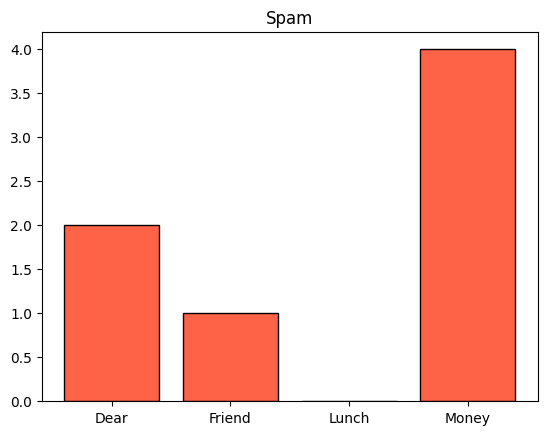

In [86]:
plt.bar(spam.columns, spam.sum().values, color='tomato', edgecolor='black')
plt.title('Spam')
plt.show()

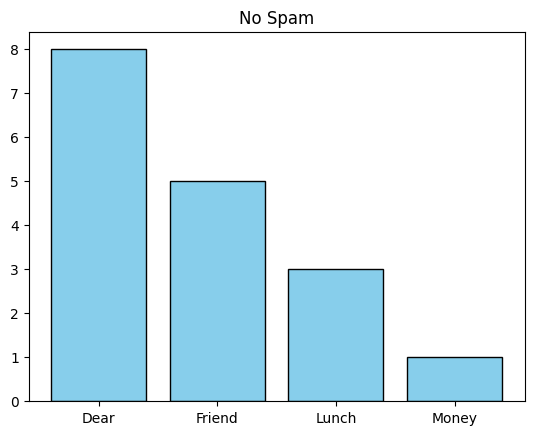

In [87]:
plt.bar(no_spam.columns, no_spam.sum().values, color='skyblue', edgecolor='black')
plt.title('No Spam')
plt.show()

## Cálculo das probabilidades

In [88]:
#Probabilidades das palavras
tno_spam = no_spam.sum().sum()
pdear = np.sum(dear) / tno_spam
pfriend = np.sum(friend) / tno_spam
plunch = np.sum(lunch) / tno_spam
pmoney = np.sum(money) / tno_spam

tspam = spam.sum().sum()
pdearS = np.sum(dearS) / tspam
pfriendS = np.sum(friendS) / tspam
plunchS = np.sum(lunchS) / tspam
pmoneyS = np.sum(moneyS) / tspam

c = 2
print(f'Probabilidades das palavras quando não spam:')
print(f'{"dear":<5} | {"friend":<3} | {"lunch":<3} | {"money":<8}')
print(f'{pdear:.{c}f}  |  {pfriend:.{c}f}  | {plunch:.{c}f}  | {pmoney:.{c}f}\n')

print(f'Probabilidades das palavras quando spam:')
print(f'{"dear":<5} | {"friend":} | {"lunch":<3} | {"money":<3}')
print(f'{pdearS:.{c}f}  |  {pfriendS:.{c}f}  | {plunchS:.{c}f}  | {pmoneyS:.{c}f}\n')

Probabilidades das palavras quando não spam:
dear  | friend | lunch | money   
0.47  |  0.29  | 0.18  | 0.06

Probabilidades das palavras quando spam:
dear  | friend | lunch | money
0.29  |  0.14  | 0.00  | 0.57



In [89]:
# probas das classes
p_no_spam = no_spam.shape[0] / (spam.shape[0] + no_spam.shape[0])
p_spam = spam.shape[0] / (spam.shape[0] + no_spam.shape[0])

print(f'p(not spam): {p_no_spam:.{2}f}')
print(f'p(spam): {p_spam:.{2}f}\n')

p(not spam): 0.67
p(spam): 0.33



## Previsão usando Naive Bayes

A probabilidade de uma classe (c) dado um conjunto de observações (x) é dada por:
$$
p(c_k) \times \prod_1^n {p(x_i | c_k)}
$$
<br>
* p(c_k): Probabilidade geral (a priori) da classe
* $\prod_1^n {p(x_i | c_k)}$: Produto das probabilidades das palavras (x) condicionadas à classe (c).

In [90]:
def naive_bayes_predict(email_words, prob_words_given_not_spam, prob_words_given_spam, prob_not_spam, prob_spam):
    # Calcula a probabilidade para cada classe
    # Inicialmente com P(classe)
    prob_not_spam_given_words = prob_not_spam
    prob_spam_given_words = prob_spam

    # Para cada palavra no email, aplica P(classe | x_i)
    for word in email_words:
        prob_not_spam_given_words *= prob_words_given_not_spam[word] #.get(word, 1e-5)  # Usa 1e-5 para palavras desconhecidas
        prob_spam_given_words *= prob_words_given_spam[word] #.get(word, 1e-5)

    print(f'P(not spam | email): {prob_not_spam_given_words}')
    print(f'P(spam | email): {prob_spam_given_words}')

    return "Spam" if prob_spam_given_words > prob_not_spam_given_words else "Not Spam"

prob_no_spam = {'dear': pdear, 'friend': pfriend, 'lunch': plunch, 'money': pmoney}
prob_spam = {'dear': pdearS, 'friend': pfriendS, 'lunch': plunchS, 'money': pmoneyS}

email = "lunch money money money money".split()

# Previsão
resultado = naive_bayes_predict(email, prob_no_spam, prob_spam, p_no_spam, p_spam)
print("O e-mail foi classificado como:", resultado)

P(not spam | email): 1.4085925554474851e-06
P(spam | email): 0.0
O e-mail foi classificado como: Not Spam


### Segunda previsão
> p(spam | lunch) = 0, <br>portanto é adicionada uma amostra para cada classe, possuindo todas as palavras.

In [91]:
spam.loc[spam.shape[0]] = [1] * 4
no_spam.loc[no_spam.shape[0]] = [1] * 4

In [92]:
#Probabilidade 2 das palavras
tno_spam = no_spam.sum().sum()
pdear = no_spam.sum()['Dear'] / tno_spam
pfriend = no_spam.sum()['Friend'] / tno_spam
plunch = no_spam.sum()['Lunch'] / tno_spam
pmoney = no_spam.sum()['Money'] / tno_spam

tspam = spam.sum().sum()
pdearS = spam.sum()['Dear'] / tspam
pfriendS = spam.sum()['Friend'] / tspam
plunchS = spam.sum()['Lunch'] / tspam
pmoneyS = spam.sum()['Money'] / tspam

c = 2
print(f'Probabilidades das palavras quando não spam:')
print(f'{"dear":<5} | {"friend":<3} | {"lunch":<3} | {"money":<8}')
print(f'{pdear:.{c}f}  |  {pfriend:.{c}f}  | {plunch:.{c}f}  | {pmoney:.{c}f}\n')

print(f'Probabilidades das palavras quando spam:')
print(f'{"dear":<5} | {"friend":} | {"lunch":<3} | {"money":<3}')
print(f'{pdearS:.{c}f}  |  {pfriendS:.{c}f}  | {plunchS:.{c}f}  | {pmoneyS:.{c}f}\n')

Probabilidades das palavras quando não spam:
dear  | friend | lunch | money   
0.43  |  0.29  | 0.19  | 0.10

Probabilidades das palavras quando spam:
dear  | friend | lunch | money
0.27  |  0.18  | 0.09  | 0.45



In [93]:
prob_no_spam = {'dear': pdear, 'friend': pfriend, 'lunch': plunch, 'money': pmoney}
prob_spam = {'dear': pdearS, 'friend': pfriendS, 'lunch': plunchS, 'money': pmoneyS}

email = "lunch money money money money".split()

# Previsão 2
resultado = naive_bayes_predict(email, prob_no_spam, prob_spam, p_no_spam, p_spam)
print("O e-mail foi classificado como:", resultado)

P(not spam | email): 1.0447015552912784e-05
P(spam | email): 0.0012935860897065731
O e-mail foi classificado como: Spam


---
#6. B) Transforme o exemplo que inicia no slide 7 em código.
Crie as tabelas para as três features a partir das distribuições reais usando médias e os desvios padrão dados nos slides. Plote essas distribuições em gráficos. No entanto, use os likelihoods dados nos exemplos para exemplificar em código a classificação.
Ao final, crie uma função na qual seja dada uma valores como na figura e ela retorne a classificação.



## Informações até o momento

In [94]:
sample_size = 8 # 10x mais não faz diferença

# like Troll 2
mean_popC1 = 24 #np.mean([24.3, 28.2])
std_popC1 = 4 #np.std([24.3, 28.2])

mean_sodapop1 = np.mean([750.7, 533.2])
std_sodapop1 = np.std([750.7, 533.2])

mean_candy1 = np.mean([.2, 50.5])
std_candy1 = np.std([.2, 50.5])

# don't like Troll 2
mean_popC0 = 4 #np.mean([2.1, 4.8])
std_popC0 = 2 #np.std([2.1, 4.8])

mean_sodapop0 = np.mean([120.5, 110.9])
std_sodapop0 = np.std([120.5, 110.9])

mean_candy0 = np.mean([90.7, 102.3])
std_candy0 = np.std([90.7, 102.3])

###
label = [1] * sample_size + [0] * sample_size

# someone new shows up...
sample_test = pd.DataFrame({'popcorn':[20], 'soda_pop':[500], 'candy':[25]})

## Gerando a população com base nas informações até o momento

In [95]:
np.random.seed(1)
popC1 = np.random.normal(mean_popC1, std_popC1, sample_size)
popC0 = np.random.normal(mean_sodapop0, std_sodapop0, sample_size)
popC = pd.DataFrame(np.concatenate([popC1, popC0]))

soda_pop1 = np.random.normal(mean_sodapop1, std_sodapop1, sample_size)
soda_pop0 = np.random.normal(mean_sodapop0, std_sodapop0, sample_size)
soda_pop = pd.DataFrame(np.concatenate([soda_pop1, soda_pop0]))

candy0 = np.random.normal(mean_candy0, std_candy0, sample_size)
candy1 = np.random.normal(mean_candy1, std_candy1, sample_size)
candy = pd.DataFrame(np.concatenate([candy0, candy1]))

In [96]:
dataset = pd.concat([popC, soda_pop, candy, pd.Series(label)], axis=1)
dataset.columns = ['popcorn', 'soda_pop', 'candy', 'label']
dataset

,popcorn,soda_pop,candy,label
0,30.497381,623.198432,92.514398,1
1,21.552974,546.482897,91.597807,1
2,21.887313,646.540745,92.606772,1
3,19.708126,705.331154,96.426545,1
4,27.461631,522.257664,90.019600,1
5,14.793845,766.438703,97.859611,1
6,30.979247,739.997991,106.126853,1
7,20.955172,696.596259,100.803856,1
8,117.231388,120.024109,20.525336,0
9,114.503022,112.418106,3.026132,0


## Vizualizando as distribuições e qual classe é mais provável que o novo indivíduo pertença

In [97]:
def plot_sample_in_distributions(data1, data2, label1, label2, t, sample_value):
    mean1, std1 = np.mean(data1), np.std(data1)
    mean2, std2 = np.mean(data2), np.std(data2)

    print(f"{label1} - Média: {mean1:.2f}, Desvio Padrão: {std1:.2f}")
    print(f"{label2} - Média: {mean2:.2f}, Desvio Padrão: {std2:.2f}")

    # limites do eixo X para incluir a amostra
    xmin = min(np.min(data1), np.min(data2), sample_value) - 2
    xmax = max(np.max(data1), np.max(data2), sample_value) + 2
    x = np.linspace(xmin, xmax, 100)

    # Densidades normais
    p1 = stats.norm.pdf(x, mean1, std1)
    p2 = stats.norm.pdf(x, mean2, std2)

    plt.plot(x, p1, 'g-', label=label1, linewidth=2)
    plt.plot(x, p2, 'r-', label=label2, linewidth=2)

    # posição da amostra
    plt.axvline(sample_value, color='blue', linestyle='--', label=f'Amostra {sample_value}')

    plt.title(f"Distribuições Normais - {t}")
    plt.legend()
    plt.show()

    # likelihoods para referência numérica
    likelihood1 = stats.norm.pdf(sample_value, mean1, std1)
    likelihood2 = stats.norm.pdf(sample_value, mean2, std2)

    print(f"Likelihood da amostra ({sample_value}) para {label1}: {likelihood1}")
    print(f"Likelihood da amostra ({sample_value}) para {label2}: {likelihood2}")

### Pop Corn

Like Troll 2 - Média: 23.48, Desvio Padrão: 5.29
Do not like Troll 2 - Média: 114.98, Desvio Padrão: 5.12


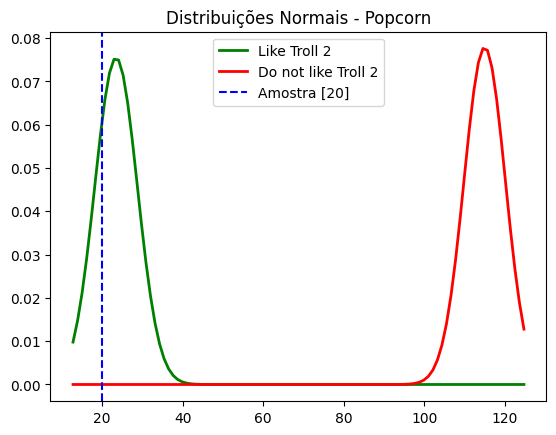

Likelihood da amostra ([20]) para Like Troll 2: [0.06076321]
Likelihood da amostra ([20]) para Do not like Troll 2: [1.76800897e-76]


In [98]:
d1 = dataset['popcorn'][dataset['label']==1]
d2 = dataset['popcorn'][dataset['label']==0]

plot_sample_in_distributions(d1, d2, 'Like Troll 2', 'Do not like Troll 2', 'Popcorn', sample_test['popcorn'].values)

### Soda Pop

Like Troll 2 - Média: 655.86, Desvio Padrão: 82.45
Do not like Troll 2 - Média: 114.70, Desvio Padrão: 2.85


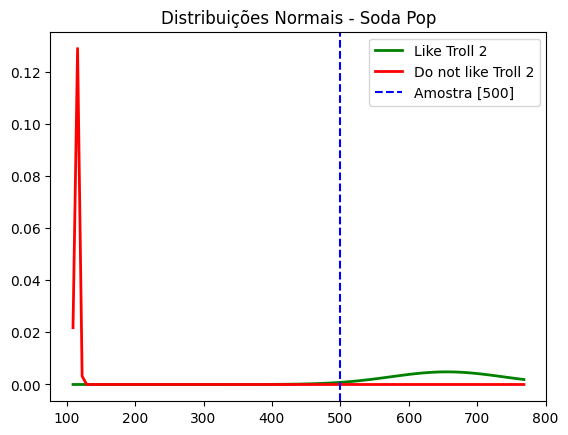

Likelihood da amostra ([500]) para Like Troll 2: [0.00081051]
Likelihood da amostra ([500]) para Do not like Troll 2: [0.]


In [99]:
d1 = dataset['soda_pop'][dataset['label']==1]
d2 = dataset['soda_pop'][dataset['label']==0]
plot_sample_in_distributions(d1, d2, 'Like Troll 2', 'Do not like Troll 2', 'Soda Pop', sample_test['soda_pop'].values)

### Candy

Like Troll 2 - Média: 95.99, Desvio Padrão: 5.10
Do not like Troll 2 - Média: 30.29, Desvio Padrão: 26.37


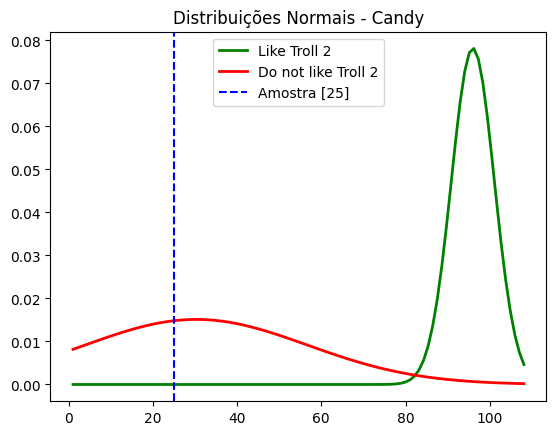

Likelihood da amostra ([25]) para Like Troll 2: [6.51930901e-44]
Likelihood da amostra ([25]) para Do not like Troll 2: [0.01482763]


In [100]:
d1 = dataset['candy'][dataset['label']==1]
d2 = dataset['candy'][dataset['label']==0]
plot_sample_in_distributions(d1, d2, 'Like Troll 2', 'Do not like Troll 2', 'Candy', sample_test['candy'].values)

## Previsão

In [101]:
x = dataset.drop('label', axis=1)
y = dataset['label']

In [102]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [104]:
model = GaussianNB()
model.fit(x, y)

sample_test = scaler.transform(sample_test)
print('Like Troll 2\n') if model.predict(sample_test) == 1 else print('Do not like Troll 2\n')

Like Troll 2



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Como apresentado nos gráficos, os valores das features dessa amostra sugerem que essa pessoa gosta de Troll 2, visto que os likelihoods das features estão mais próximas da média das distribuições da classe de indivíduos que gostam de Troll 2.

#6. C) Apply Naive Bayes to the Iris Dataset.
Da mesma forma que foi exemplificado no slide 208, aplique Naives Bayes para o dataset Iris: from sklearn.datasets import load_iris.

Usar ```sklearn.metrics.classification_report```

## Divisão de dados para treino e teste

In [ ]:
xtr, xts, ytr, yts = train_test_split(iris().data, iris().target, test_size=0.3)

In [ ]:
g_nb = GaussianNB()
g_nb.fit(xtr, ytr)

GaussianNB()

In [ ]:
predictions = g_nb.predict(xts)

## Prevendo e organizando a tabela de resultados

In [ ]:
c = np.append(iris().target_names, np.array(['accuracy', 'macro avg', 'weighted avg']),axis=0)
results = pd.DataFrame(classification_report(yts, predictions, output_dict=True))
results.columns = c

In [ ]:
results

,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
precision,1.0,1.000000,0.947368,0.977778,0.982456,0.978947
recall,1.0,0.937500,1.000000,0.977778,0.979167,0.977778
f1-score,1.0,0.967742,0.972973,0.977778,0.980238,0.977720
support,11.0,16.000000,18.000000,0.977778,45.000000,45.000000


## Métricas de classification_report

* Precisão: "Das previsões positivas, quantas estavam corretas?" **Verdadeiros positivos previstos.**
* Recall: "Das amostras reais desta classe, quantas foram identificadas corretamente?" **Verdadeiros positivos reais.**
* F1-Score: A média harmônica entre precisão e recall, equilibrando essas duas métricas.
* Support: O número de instâncias reais de cada classe no conjunto de dados de teste.
* Accuracy: "Quantas previsões o modelo acertou no total?" **A taxa de acerto global.**
* Macro avg: A média simples das métricas (precisão, recall e F1) para todas as classes.
* Weighted avg: A média ponderada das métricas, levando em conta o número de amostras de cada classe.
---
### Análise
O modelo classificou corretamente 97.78% das amostras de teste, observando a métrica acurácia. O valor da média ponderada é muito próximo da acuracia, uma vez que o dataset está relativamente balanceado, com 16, 14 e 15 amostras de cada classe.

O modelo demonstra desempenho perfeito para a classe setosa, apresentando 100% de acertos. O maior problema está em versicolor, onde algumas amostras foram classificadas incorretamente.
